In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import math
import glob
from importlib import reload

import tqdm 
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import osu.rulesets.beatmap as bm
import osu.rulesets.replay as rp
import osu.rulesets.hitobjects as hitobjects
import osu.dataset as dataset

import osu.preview.preview as preview

osu! path: C:\Users\niooi\AppData\Roaming/../Local/osu!
pygame 2.6.1 (SDL 2.28.4, Python 3.12.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


E:\Projects\osu\.venv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
obj_dataset = dataset.replay_mapping_from_cache(3500)

Loading objects from .data/: 100%|██████████| 3500/3500 [01:17<00:00, 45.23it/s]


In [3]:
obj_dataset

,replay,beatmap
0,<osu.rulesets.replay.Replay object at 0x000002...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
1,<osu.rulesets.replay.Replay object at 0x000002...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
2,<osu.rulesets.replay.Replay object at 0x000002...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
3,<osu.rulesets.replay.Replay object at 0x000002...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
4,<osu.rulesets.replay.Replay object at 0x000002...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
...,...,...
2943,<osu.rulesets.replay.Replay object at 0x000002...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
2944,<osu.rulesets.replay.Replay object at 0x000002...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
2945,<osu.rulesets.replay.Replay object at 0x000002...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
2946,<osu.rulesets.replay.Replay object at 0x000002...,<osu.rulesets.beatmap.Beatmap object at 0x0000...


In [4]:
input_data = dataset.input_data(obj_dataset, verbose=True)
output_data = dataset.target_data(obj_dataset, verbose=True)

Turning beatmaps into time series data: 100%|██████████| 2948/2948 [15:58<00:00,  3.08it/s]  
E:\Projects\osu\osu\dataset.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  tensor_list = [torch.tensor(seq, dtype=torch.float) for seq in data]
Turning replays into time series data: 100%|██████████| 2948/2948 [01:34<00:00, 31.17it/s]


In [5]:
input = input_data
output = output_data

In [6]:
output[0:500]

x         y   k1   k2
chunk frame                              
0     0     -0.220486 -0.116898  0.0  0.0
      1     -0.220486 -0.116898  0.0  0.0
      2     -0.229167 -0.108796  0.0  0.0
      3     -0.229167 -0.108796  0.0  0.0
      4     -0.227430 -0.107639  0.0  0.0
...               ...       ...  ...  ...
      495    0.107639  0.005787  0.0  1.0
      496    0.165799  0.015046  0.0  1.0
      497    0.174479  0.024305  0.0  1.0
      498    0.187500  0.041667  0.0  1.0
      499    0.187500  0.040509  0.0  1.0

[500 rows x 4 columns]

In [7]:
import torch

xs = np.reshape(input.values, (-1, dataset.BATCH_LENGTH, len(dataset.INPUT_FEATURES)))

# try:
#     target_data = pd.read_pickle('.data/target_data.dat')
# except:
#     target_data = dataset.target_data(dataset, verbose=True)
#     target_data.to_pickle('.data/target_data.dat')

ys = np.reshape(output.values, (-1, dataset.BATCH_LENGTH, len(dataset.OUTPUT_FEATURES)))

xs.shape

(11282, 2048, 5)

In [8]:
xs

array([[[-0.35546875, -0.5       ,  1.        ,  1.        ,
          0.        ],
        [-0.35546875, -0.5       ,  0.94666666,  1.        ,
          0.        ],
        [-0.35546875, -0.5       ,  0.8933333 ,  1.        ,
          0.        ],
        ...,
        [-0.41601562, -0.03125   ,  0.12888889,  1.        ,
          0.        ],
        [-0.41601562, -0.03125   ,  0.07555556,  1.        ,
          0.        ],
        [-0.41601562, -0.03125   ,  0.02222222,  1.        ,
          0.        ]],

       [[-0.42578125, -0.0546875 ,  0.        ,  1.        ,
          0.        ],
        [-0.4375    , -0.09375   ,  0.        ,  1.        ,
          0.        ],
        [-0.44140625, -0.13802083,  0.        ,  1.        ,
          0.        ],
        ...,
        [ 0.328125  ,  0.3828125 ,  0.19333333,  1.        ,
          0.        ],
        [ 0.328125  ,  0.3828125 ,  0.14      ,  1.        ,
          0.        ],
        [ 0.328125  ,  0.3828125 ,  0.08666667, 

In [9]:
# ys = ys[0:xs.shape[0]]

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from random import randint 
from torch.utils.data import DataLoader, TensorDataset

BATCH_SIZE = 128

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 
# x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.2, random_state=randint(0, 100))
# 
# train_dataset = TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
# 
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [92]:
from osu.gan import OsuReplayGAN
from osu.rnn import OsuReplayRNN

In [93]:
print("Creating RNN model...")
rnn = OsuReplayRNN(batch_size=BATCH_SIZE, noise_std=0.00)
rnn.load_data(xs, ys)

Creating RNN model...
RNN Model initialized on cuda (noise_std=0.0)
Model parameters: 226244
Data loaded: 9025 training samples, 2257 test samples


Epoch 1/10 (Train): 100%|██████████| 71/71 [00:10<00:00,  6.55it/s]


Epoch 1/10, Train Loss: 0.5945, Test Loss: 0.5489


Epoch 2/10 (Train): 100%|██████████| 71/71 [00:10<00:00,  6.68it/s]


Epoch 2/10, Train Loss: 0.4823, Test Loss: 0.4305


Epoch 3/10 (Train): 100%|██████████| 71/71 [00:10<00:00,  6.60it/s]


Epoch 3/10, Train Loss: 0.4249, Test Loss: 0.4156


Epoch 4/10 (Train): 100%|██████████| 71/71 [00:10<00:00,  6.63it/s]


Epoch 4/10, Train Loss: 0.4165, Test Loss: 0.4176


Epoch 5/10 (Train): 100%|██████████| 71/71 [00:10<00:00,  6.52it/s]


Epoch 5/10, Train Loss: 0.4200, Test Loss: 0.4102


Epoch 6/10 (Train): 100%|██████████| 71/71 [00:10<00:00,  6.82it/s]


Epoch 6/10, Train Loss: 0.4090, Test Loss: 0.4044


Epoch 7/10 (Train): 100%|██████████| 71/71 [00:10<00:00,  7.07it/s]


Epoch 7/10, Train Loss: 0.4078, Test Loss: 0.4064


Epoch 8/10 (Train): 100%|██████████| 71/71 [00:10<00:00,  7.00it/s]


Epoch 8/10, Train Loss: 0.4060, Test Loss: 0.4020


Epoch 9/10 (Train): 100%|██████████| 71/71 [00:10<00:00,  7.04it/s]


Epoch 9/10, Train Loss: 0.4050, Test Loss: 0.4026


Epoch 10/10 (Train): 100%|██████████| 71/71 [00:10<00:00,  7.09it/s]


Epoch 10/10, Train Loss: 0.4044, Test Loss: 0.4015


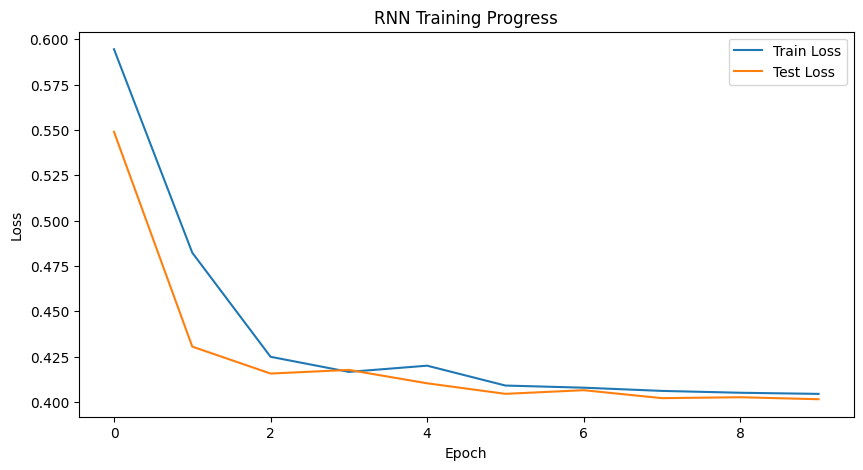

RNN model saved to .trained/rnn_2025-07-15_16-40-36.pt


In [94]:
RNN_EPOCHS = 10

# Train the RNN
rnn.train(epochs=RNN_EPOCHS)
rnn.plot_losses()
rnn.save()

In [81]:
# import torch
# import gc
# 
# # Clear GPU cache
# torch.cuda.empty_cache()
# 
# # Force garbage collection
# gc.collect()

1405

In [14]:
print("Creating GAN model...")
gan = OsuReplayGAN(batch_size=BATCH_SIZE, noise_dim=4)
gan.load_data(xs, ys)

Creating GAN model...
GAN Models initialized on cuda (noise_dim=4)
Generator parameters: 213732
Discriminator parameters: 55105
Data loaded: 9025 training samples, 2257 test samples


Epoch 1/15 (GAN): 100%|██████████| 71/71 [01:31<00:00,  1.28s/it]


Epoch 1/15, Gen Loss: 2.2418, Disc Loss: 0.6939


Epoch 2/15 (GAN): 100%|██████████| 71/71 [01:28<00:00,  1.25s/it]


Epoch 2/15, Gen Loss: 2.0513, Disc Loss: 0.6855


Epoch 3/15 (GAN): 100%|██████████| 71/71 [01:29<00:00,  1.26s/it]


Epoch 3/15, Gen Loss: 2.0141, Disc Loss: 0.5713


Epoch 4/15 (GAN): 100%|██████████| 71/71 [01:28<00:00,  1.25s/it]


Epoch 4/15, Gen Loss: 2.0012, Disc Loss: 0.4008


Epoch 5/15 (GAN): 100%|██████████| 71/71 [01:29<00:00,  1.27s/it]


Epoch 5/15, Gen Loss: 2.0448, Disc Loss: 0.3610


Epoch 6/15 (GAN): 100%|██████████| 71/71 [01:29<00:00,  1.25s/it]


Epoch 6/15, Gen Loss: 1.8723, Disc Loss: 0.7065


Epoch 7/15 (GAN): 100%|██████████| 71/71 [01:30<00:00,  1.27s/it]


Epoch 7/15, Gen Loss: 1.8157, Disc Loss: 0.7022


Epoch 8/15 (GAN): 100%|██████████| 71/71 [01:28<00:00,  1.25s/it]


Epoch 8/15, Gen Loss: 1.8176, Disc Loss: 0.6999


Epoch 9/15 (GAN): 100%|██████████| 71/71 [01:30<00:00,  1.27s/it]


Epoch 9/15, Gen Loss: 1.8076, Disc Loss: 0.6990


Epoch 10/15 (GAN): 100%|██████████| 71/71 [01:29<00:00,  1.25s/it]


Epoch 10/15, Gen Loss: 1.8023, Disc Loss: 0.6982


Epoch 11/15 (GAN): 100%|██████████| 71/71 [01:29<00:00,  1.27s/it]


Epoch 11/15, Gen Loss: 1.7879, Disc Loss: 0.6975


Epoch 12/15 (GAN): 100%|██████████| 71/71 [01:29<00:00,  1.25s/it]


Epoch 12/15, Gen Loss: 1.7721, Disc Loss: 0.6969


Epoch 13/15 (GAN): 100%|██████████| 71/71 [01:29<00:00,  1.27s/it]


Epoch 13/15, Gen Loss: 1.7709, Disc Loss: 0.6956


Epoch 14/15 (GAN): 100%|██████████| 71/71 [01:28<00:00,  1.25s/it]


Epoch 14/15, Gen Loss: 1.7564, Disc Loss: 0.6957


Epoch 15/15 (GAN): 100%|██████████| 71/71 [01:29<00:00,  1.26s/it]

Epoch 15/15, Gen Loss: 1.7427, Disc Loss: 0.6957


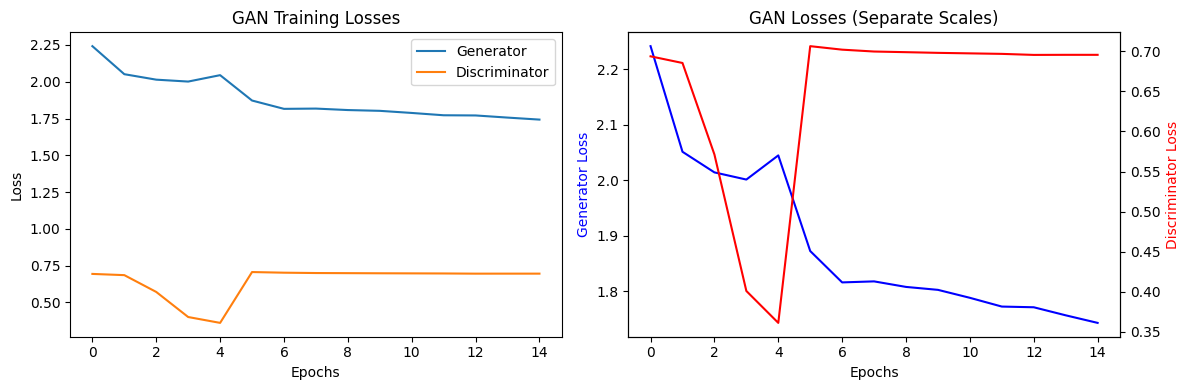

GAN models saved with prefix .trained/gan_2025-07-15_05-39-28


In [15]:
GAN_EPOCHS = 15

# Train the GAN
gan.train(epochs=GAN_EPOCHS, lambda_recon=10.0)
gan.plot_losses()
gan.save()

In [28]:
from osu.rulesets.mods import Mods
import osu.rulesets.beatmap as bm
import osu.rulesets.replay as rp
import osu.dataset as dataset

test_name = 'rubiks'
test_mods = Mods.HARD_ROCK
test_map_path = f'assets/{test_name}_map.osu'
test_song = f'assets/{test_name}_song.mp3'

test_map = bm.load(test_map_path)
test_map.apply_mods(test_mods)

data = dataset.input_data(test_map)
data = np.reshape(data.values, (-1, dataset.BATCH_LENGTH, len(dataset.INPUT_FEATURES)))
data = torch.FloatTensor(data)

Turning beatmaps into time series data: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


In [29]:
with torch.no_grad():
    # Use generator for inference
    replay_data = rnn.generate(data)
    
replay_data = np.concatenate(replay_data)
if not os.path.exists('.generated'):
    os.makedirs('.generated')
    
np.save('.generated\\' + test_name + '.npy', replay_data)

print(f"Generated replay data shape: {replay_data.shape}")
print(f"Saved to .generated\\{test_name}.npy")

Generated replay data shape: (8192, 4)
Saved to .generated\rubiks.npy


In [30]:
replay_data[:500]

array([[-0.02848415,  0.00946948,  0.        ,  0.        ],
       [-0.03079884, -0.00257415,  0.        ,  0.        ],
       [-0.04895214, -0.00523007,  0.        ,  0.        ],
       ...,
       [-0.06873588,  0.17758213,  1.        ,  0.        ],
       [-0.07033934,  0.1979261 ,  1.        ,  0.        ],
       [-0.07712197,  0.24043933,  1.        ,  0.        ]],
      shape=(500, 4), dtype=float32)

In [31]:
import importlib
import osu.preview.preview as preview

importlib.reload(preview)

preview.preview_replay_raw(replay_data, test_map_path, test_mods, test_song)

k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
k1 released
k1 pressed
